## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

x_tf = tf.Variable(X_train, dtype = tf.float32)
y_tf = tf.Variable(y_train, dtype = tf.uint8)
train_accuracy = eval_acc(model, x_tf, y_tf)
train_acc = train_accuracy.numpy()
print('train acc = {}'.format(train_acc))

epoch 1: valid acc = 0.7350000143051147
epoch 2: valid acc = 0.7940000295639038
epoch 3: valid acc = 0.8320000171661377
epoch 4: valid acc = 0.8460000157356262
epoch 5: valid acc = 0.8510000109672546
epoch 6: valid acc = 0.8569999933242798
epoch 7: valid acc = 0.8610000014305115
epoch 8: valid acc = 0.8709999918937683
epoch 9: valid acc = 0.871999979019165
epoch 10: valid acc = 0.8769999742507935
epoch 11: valid acc = 0.8769999742507935
epoch 12: valid acc = 0.8790000081062317
test acc = 0.857699990272522
train acc = 0.8799796104431152


In [4]:
# for lr in [0.1,0.01,0.001,0.0001]:
#     for e in range(num_epochs):
#         for i in range(num_batch):
#             batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
#             x_tf = tf.Variable(batch_xs, dtype = tf.float32)
#             y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
#             grads = grad(model, x_tf, y_tf, reg_tf)
#             #optimization based on calculated gradients 
#             optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

#         x_tf = tf.Variable(X_val, dtype = tf.float32)
#         y_tf = tf.Variable(y_val, dtype = tf.uint8)
#         accuracy = eval_acc(model, x_tf, y_tf)
#         val_acc = accuracy.numpy()
#         print('epoch {}: valid acc = {}'.format(e+1, val_acc))

#     x_tf = tf.Variable(X_test, dtype = tf.float32)
#     y_tf = tf.Variable(y_test, dtype = tf.uint8)
#     accuracy = eval_acc(model, x_tf, y_tf)
#     test_acc = accuracy.numpy()
#     print('test acc = {}'.format(test_acc))

#     x_tf = tf.Variable(X_train, dtype = tf.float32)
#     y_tf = tf.Variable(y_train, dtype = tf.uint8)
#     train_accuracy = eval_acc(model, x_tf, y_tf)
#     train_acc = train_accuracy.numpy()
#     print('train acc = {}'.format(train_acc))

### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

<span style="color:red"><strong>Solution</strong></span>:

In [5]:

hidden_dims = [128,256,256]
reg_tf = tf.constant(0.001)

# define a tf.keras.Model class
class DeeperModel(tf.keras.Model):
    def __init__(self):
        super(DeeperModel, self).__init__()
        
#         self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dims[0]).astype('float32'))
#         self.b1 = tf.Variable(np.zeros((hidden_dims[0],)).astype('float32'))
        
#         self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dims[0], hidden_dims[1]).astype('float32'))
#         self.b2 = tf.Variable(np.zeros((hidden_dims[1],)).astype('float32'))
        
#         self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dims[1], hidden_dims[2]).astype('float32'))
#         self.b3 = tf.Variable(np.zeros((hidden_dims[2],)).astype('float32'))
        
#         self.W4 = tf.Variable(1e-2*np.random.rand(hidden_dims[2], 20).astype('float32'))
#         self.b4 = tf.Variable(np.zeros((20,)).astype('float32'))
        
        self.depth = len(hidden_dims)
        self.params = []
        for i in range(0,self.depth):
            if i == 0:
                self.params.append(tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dims[0]).astype('float32')))
                self.params.append(tf.Variable(np.zeros((hidden_dims[0],)).astype('float32')))
            elif i == self.depth-1:
                self.params.append(tf.Variable(1e-2*np.random.rand(hidden_dims[i-1], 20).astype('float32')))
                self.params.append(tf.Variable(np.zeros((20,)).astype('float32')))
            else:
                self.params.append(tf.Variable(1e-2*np.random.rand(hidden_dims[i-1], hidden_dims[i]).astype('float32')))
                self.params.append(tf.Variable(np.zeros((hidden_dims[i],)).astype('float32')) )
        # print(self.params)
        
#         for p in self.params:
#             print(p.shape)
        
        
        
    def call(self, inputs):
        """Run the model."""
#         h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
#         h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
#         h3 = tf.nn.relu(tf.matmul(h2, self.W3) + self.b3)
#         out = tf.matmul(h3, self.W4) + self.b4
        
        for i in range(0, 2*self.depth, 2):
            if i == 0:
                h = tf.nn.relu(tf.matmul(inputs, self.params[0]) + self.params[1])
            elif i == 2*self.depth-2:
                out = tf.matmul(h, self.params[i]) + self.params[i+1]
            else:
                h = tf.nn.relu(tf.matmul(h, self.params[i]) + self.params[i+1])
        
        
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    # L2_loss = tf.nn.l2_loss(model.W1)+tf.nn.l2_loss(model.W2)+tf.nn.l2_loss(model.W3)+tf.nn.l2_loss(model.W4)
    L2_loss = tf.nn.l2_loss(model.params[0])
    for i in range(2,2*model.depth,2):
        L2_loss = L2_loss + tf.nn.l2_loss(model.params[i])
    
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
        # print(loss_value)
    # return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4])
    return tape.gradient(loss_value, model.params )

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 50
model = DeeperModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, model.params))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))


x_tf = tf.Variable(X_train, dtype = tf.float32)
y_tf = tf.Variable(y_train, dtype = tf.uint8)
train_accuracy = eval_acc(model, x_tf, y_tf)
train_acc = train_accuracy.numpy()
print('train acc = {}'.format(train_acc))

epoch 1: valid acc = 0.25200000405311584
epoch 2: valid acc = 0.382999986410141
epoch 3: valid acc = 0.4169999957084656
epoch 4: valid acc = 0.48100000619888306
epoch 5: valid acc = 0.5529999732971191
epoch 6: valid acc = 0.5559999942779541
epoch 7: valid acc = 0.6029999852180481
epoch 8: valid acc = 0.5830000042915344
epoch 9: valid acc = 0.6399999856948853
epoch 10: valid acc = 0.6880000233650208
epoch 11: valid acc = 0.7139999866485596
epoch 12: valid acc = 0.7239999771118164
epoch 13: valid acc = 0.7300000190734863
epoch 14: valid acc = 0.7450000047683716
epoch 15: valid acc = 0.7590000033378601
epoch 16: valid acc = 0.7720000147819519
epoch 17: valid acc = 0.777999997138977
epoch 18: valid acc = 0.7789999842643738
epoch 19: valid acc = 0.7879999876022339
epoch 20: valid acc = 0.7950000166893005
epoch 21: valid acc = 0.8029999732971191
epoch 22: valid acc = 0.8130000233650208
epoch 23: valid acc = 0.8140000104904175
epoch 24: valid acc = 0.8190000057220459
epoch 25: valid acc = 0.8

### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

<span style="color:red"><strong>SOLUTION</strong></span>:

In [6]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
  # tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(l2=1e-3)),
  tf.keras.layers.Dense(256,activation="relu",kernel_regularizer=regularizers.l2(l2=1e-3)),  
  tf.keras.layers.Dense(256,activation="relu",kernel_regularizer=regularizers.l2(l2=1e-3)),
  tf.keras.layers.Dense(20,activation="softmax",  kernel_regularizer=regularizers.l2(l2=1e-3))
  # tf.keras.layers.Dense(3, kernel_regularizer='l2')
])



# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss
model.compile(
    # optimizer=tf.keras.optimizers.Adam(0.001),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset


model.fit(
    x = X_train, 
    y = y_train, 
    batch_size = 500,
    epochs=50,
    verbose = 2,
    validation_data=(X_val,y_val),
    shuffle = True
)
model.summary()

# END of your code
#############################################################

Epoch 1/50


C:\Users\31557\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


98/98 - 1s - loss: 6.6642 - sparse_categorical_accuracy: 0.6794 - val_loss: 3.1053 - val_sparse_categorical_accuracy: 0.7680 - 758ms/epoch - 8ms/step
Epoch 2/50
98/98 - 0s - loss: 2.9083 - sparse_categorical_accuracy: 0.7658 - val_loss: 2.5112 - val_sparse_categorical_accuracy: 0.7870 - 386ms/epoch - 4ms/step
Epoch 3/50
98/98 - 0s - loss: 2.3679 - sparse_categorical_accuracy: 0.7851 - val_loss: 2.3679 - val_sparse_categorical_accuracy: 0.7930 - 373ms/epoch - 4ms/step
Epoch 4/50
98/98 - 0s - loss: 2.0482 - sparse_categorical_accuracy: 0.8016 - val_loss: 2.0892 - val_sparse_categorical_accuracy: 0.7980 - 378ms/epoch - 4ms/step
Epoch 5/50
98/98 - 0s - loss: 1.8557 - sparse_categorical_accuracy: 0.8123 - val_loss: 2.0479 - val_sparse_categorical_accuracy: 0.7930 - 381ms/epoch - 4ms/step
Epoch 6/50
98/98 - 0s - loss: 1.7179 - sparse_categorical_accuracy: 0.8202 - val_loss: 2.0356 - val_sparse_categorical_accuracy: 0.7940 - 377ms/epoch - 4ms/step
Epoch 7/50
98/98 - 0s - loss: 1.6057 - sparse

## Part 2: t-SNE (optional, bonus +5 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [7]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [8]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [9]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.952302930286705
The 100 th loop cost: 11.791638580012133, computation time: 0.9461367130279541
The 200 th loop cost: 0.5314782087531726, computation time: 1.876450538635254
The 300 th loop cost: 0.49967112176327816, computation time: 2.8183889389038086
The 400 th loop cost: 0.49445104654268185, computation time: 3.751099109649658
The 500 th loop cost: 0.4932506114149763, computation time: 4.67635178565979
The 600 th loop cost: 0.49277781338300086, computation time: 5.616339206695557
The 700 th loop cost: 0.4925521777945765, computation time: 6.5461201667785645
The 800 th loop cost: 0.4924327808920234, computation time: 7.489293575286865
The 900 th loop cost: 0.492365717107873, computation time: 8.42598581314087
The 1000 th loop cost: 0.4923262042560777, computation time: 9.372772932052612
it takes 9.681288957595825 seconds


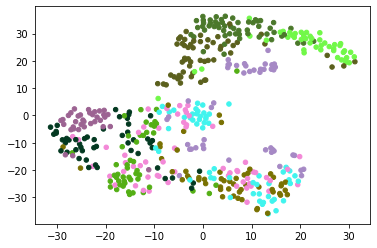

In [10]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [62]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.227, new learning rate = 0.00095
epoch 2: valid acc = 0.262, new learning rate = 0.0009025
epoch 3: valid acc = 0.322, new learning rate = 0.000857375
epoch 4: valid acc = 0.348, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.331, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.382, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.376, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.408, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.393, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.388, new learning rate = 0.0005987369392383785
test acc: 0.3774


0.3774

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [70]:
import keras

model_keras = tf.keras.Sequential()
model_keras.add(tf.keras.layers.Input(shape = (784,)))
model_keras.add(tf.keras.layers.Dense(100,"relu"))
model_keras.add(tf.keras.layers.Dense(20))

model_keras.compile(
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              optimizer=tf.keras.optimizers.SGD(0.001),
              metrics=['accuracy']) 

model_keras.fit(X_train, tf.one_hot(y_train,20),validation_data = (X_val, tf.one_hot(y_val,20)), batch_size=200, epochs=10) 

Epoch 1/10
245/245 [==============================] - 1s 1ms/step - loss: 10.6682 - accuracy: 0.7541 - val_loss: 5.0962 - val_accuracy: 0.7980
Epoch 2/10
245/245 [==============================] - 0s 1ms/step - loss: 3.9205 - accuracy: 0.8153 - val_loss: 3.3574 - val_accuracy: 0.8030
Epoch 3/10
245/245 [==============================] - 0s 1ms/step - loss: 2.6093 - accuracy: 0.8268 - val_loss: 2.8013 - val_accuracy: 0.8020
Epoch 4/10
245/245 [==============================] - 0s 1ms/step - loss: 1.9964 - accuracy: 0.8368 - val_loss: 1.8634 - val_accuracy: 0.8290
Epoch 5/10
245/245 [==============================] - 0s 1ms/step - loss: 1.5908 - accuracy: 0.8416 - val_loss: 1.6812 - val_accuracy: 0.8340
Epoch 6/10
245/245 [==============================] - 0s 1ms/step - loss: 1.2820 - accuracy: 0.8493 - val_loss: 1.5628 - val_accuracy: 0.8240
Epoch 7/10
245/245 [==============================] - 0s 1ms/step - loss: 1.1230 - accuracy: 0.8529 - val_loss: 1.5322 - val_accuracy: 0.8200
Epoch

In [75]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################

# h = model.layers[1].feedforward(model.layers[0].feedforward(X))

def softmax(x):
    # x.shape (N,o) 
    # x = x.reshape(-1,1)
    N = x.shape[0]
    ex = np.exp(x)
    softmax = ex/( np.sum(ex,axis=1).reshape(N,1) )
    y_hat = np.argmax(softmax, axis=1)
    Y = np.zeros_like(x)
    Y[range(N), y_hat] = 1
    return y_hat # Y

# print(model.num_layers)  2

for l in range(model.num_layers):
    print("layer",l)
    X = model.layers[l].feedforward(X)

# print(X, X.shape)  (500, 20)
    
# print(h.shape,softmax(h).shape)
# print(model.predict(X).shape)

h = softmax(X)
print(h,h.shape)


Y = tsne(h, low_dim=2, perplexity=30.0)


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

layer 0
layer 1
[7 2 2 1 2 2 7 7 7 8 7 4 7 7 7 7 7 7 8 2 7 7 7 4 7 7 0 0 7 7 7 2 0 2 9 7 7
 7 2 7 7 2 4 7 7 8 9 7 7 7 7 0 3 2 7 7 2 7 7 2 7 7 4 0 0 7 7 0 8 7 7 7 7 7
 7 0 7 7 0 2 7 7 7 7 4 7 7 7 7 7 0 7 4 8 7 2 7 4 9 7 0 7 7 7 8 2 7 7 0 7 7
 7 7 7 9 2 2 7 7 7 3 4 0 7 7 2 7 8 7 7 7 7 9 7 8 7 7 7 2 7 7 7 7 7 7 8 7 7
 0 3 7 2 8 7 2 0 7 0 0 0 7 0 0 7 7 4 9 7 7 7 9 2 2 7 7 8 7 2 7 9 4 7 0 7 0
 8 0 4 2 7 7 7 2 4 2 7 7 7 7 7 8 7 7 0 7 4 7 2 7 8 2 7 2 7 8 7 7 7 2 3 7 7
 7 7 2 7 0 9 2 7 0 2 7 0 2 8 7 4 0 7 7 0 2 9 0 7 7 8 7 7 7 2 4 0 0 7 2 2 7
 9 7 2 7 0 7 2 7 7 0 7 2 7 9 7 2 7 2 4 7 7 0 7 7 7 7 7 8 7 7 4 0 3 7 9 7 7
 4 7 0 0 7 7 4 7 7 0 7 2 7 7 7 0 2 7 0 0 0 7 2 8 7 2 2 7 7 7 7 7 7 7 0 3 7
 2 2 7 0 2 7 7 7 7 7 0 7 7 7 9 2 0 9 7 8 7 7 7 2 7 7 7 4 7 0 8 2 8 2 7 7 2
 7 7 9 2 2 9 7 2 2 7 4 9 8 7 7 0 2 8 2 7 0 0 8 7 8 7 7 2 7 7 0 2 2 7 4 7 2
 7 7 2 2 8 7 2 7 0 0 0 4 2 7 7 9 2 7 7 7 4 7 7 8 2 7 7 8 0 2 2 7 7 4 7 7 9
 8 2 4 7 8 7 6 2 7 7 2 7 2 7 7 7 7 7 7 7 7 7 9 7 7 2 7 7 9 7 7 0 7 9 7 0 7
 7 7 9 7 

ValueError: not enough values to unpack (expected 2, got 1)

In [73]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################

labels = Y#  y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [110]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################


tic = time.time()
h = model.layers[1].feedforward(model.layers[0].feedforward(X))

def softmax(x):
    N = x.shape[0]
    ex = np.exp(x)
    softmax = ex/( np.sum(ex,axis=1).reshape(N,1) )
    y_hat = np.argmax(softmax, axis=1)
    Y = np.zeros_like(x)
    Y[range(N), y_hat] = 1
    return Y


Y = tsne(softmax(h), low_dim=10, perplexity=50.0)


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.19968192466266999
The 100 th loop cost: 7.087246903909275, computation time: 1.1312649250030518
The 200 th loop cost: 0.043641245548307034, computation time: 2.290550470352173
The 300 th loop cost: 0.03398065136499334, computation time: 3.3973052501678467
The 400 th loop cost: 0.032395857818861465, computation time: 4.4920573234558105
The 500 th loop cost: 0.03201141632089565, computation time: 5.654825210571289
The 600 th loop cost: 0.03184317760278019, computation time: 6.782080173492432
The 700 th loop cost: 0.03175273846260507, computation time: 7.926173686981201
The 800 th loop cost: 0.031693132826145616, computation time: 9.050486326217651
The 900 th loop cost: 0.031654282362404806, computation time: 10.174244403839111
The 1000 th loop cost: 0.03162931791243458, computation time: 11.30650019645691
it takes 12.004657983779907 seconds


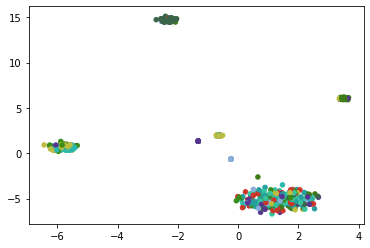

In [111]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################